# Attitude tracking control on SO(3)

This is developed as a final project for BYU's ECEN774 Nonlinear Systems course.
It follows the control derivations by Taeyoung Lee in [Global Exponential Attitude Tracking Controls on SO(3)](https://arxiv.org/abs/1209.2926).


In [2]:
import LinearAlgebra
LA = LinearAlgebra
using Plots
using LaTeXStrings
Plots.scalefontsizes(1.0)
using ForwardDiff

## Super brief Lie theory for SO(3)
* Rotation matrices are members of the Lie group $\mathsf{SO(3)} = \{R \in \mathbb{R}^{3\times3} | R^T R = I, \mathrm{det}[R] = 1\}$. That is, the set of orthogonal $3\times3$ matrices with determinant 1.
* Every Lie Group has an associated Lie algebra which is the tangent space at the identity element. Derivatives or perturbations of members of a Lie group occur in the Lie algebra. For rotation matrices, the identity element is the identity matrix, $I$, and the Lie algebra is $\mathfrak{so}(3)$, the set of skew-symmetric matrices. The Lie algebra is isomorphic to $\mathbb{R}^3$, and the mapping is $(\cdot)^\wedge : \mathbb{R}^3 \to \mathfrak{so}(3)$. Note that this mapping corresponds to that of the cross operator $[\cdot]_\times$. 
* The exponential map $\mathrm{exp}: \mathfrak{so}(3) \to \mathsf{SO(3)}$ can be used to find the effect of perturbations on a rotation matrix. A common notational shortcut to use for finding the difference between elements in a group or incrementing an elemeent in a group. 

In [3]:
lie_eps = 1e-8 # used to check functions for places with numerical problems

function crossMat(w)
    """
    computes the skew-symmetric matrix from a 3-vector
    """
    wx = [0.0 -w[3] w[2]; w[3] 0.0 -w[1]; -w[2] w[1] 0.0]
    return wx
end

function hat(tau)
    """
    Computes the hat map, which maps from R^3 -> so(3)
    """
    return crossMat(tau)
end 

function vee(taux)
    """
    Computes the vee map, which maps from so(3) -> R^3
    """
    tau = [taux[3,2], taux[1, 3], taux[2,1]]
    return tau
end 

function expSO3(wx)
    """
    Computes the exponential map, which maps from so(3) -> SO(3)
    see Jackson's Transformations for Dummies for an explanation of the math
    """
    # find the angle/axis representation
    w = vee(wx)
    
    # ||w||
    theta = LA.norm(w) # Note: sqrt(w'*w) failed for autodiff of vectors with magnitude 0 
    if (theta > 0.0 + lie_eps)
        # use large-angle (Rodriguez formula)
        R = LA.I + wx*(sin(theta)/theta) + wx*wx*((1-cos(theta))/theta^2)
    else
        # use small-angle (Taylor expansion)
        R = LA.I + wx*(1 - theta^2/6 + theta^4/120 ) + wx*wx*(1/2 - theta^2/24 + theta^4/720)
    end
    return R
end

function logSO3(R)
    """
    Computes the logarithmic map, which maps from SO(3) -> so(3)
    see Jackson's Transformations for Dummies for an explanation of the math
    """
    
    #### TODO ####
    temp = (LA.tr(R) - 1.0)/2.0
    if temp > 1.0
        temp = 1.0
    elseif temp < 0.0
        temp = 0.0
    end
    
    theta = acos(temp)
    
    if (theta > 0+ lie_eps && theta < pi/2 - lie_eps)
        # use large-angle
        logR = (theta/(2*sin(theta)))*(R-R')
    else
        # use small angle (Taylor Series)
        logR = (1.0/2.0)*(1+(1/6)*theta^2 + (7/360)*theta^4)*(R-R')
    end
    
    return logR
end

function rot2euler(R)
    """
    Convert a rotation matrix to euler angles for plotting
    """
    if abs(R[3,1]) <= (1.0 - lie_eps) # R31 != 1.0
        theta = -asin(R[3,1])
        ctheta = cos(theta)
        psi = atan(R[3,2]/ctheta, R[3,3]/ctheta)
        phi = atan(R[2,1]/ctheta, R[1,1]/ctheta)
    else
        phi = 0
        if R[3,1] < 0
            theta = pi/2
            psi = phi + atan(R[1,2], R[1,3])
        else
            theta = -pi/2
            psi = -phi + atan(-R[1,2], -R[1,3])
        end
    end
    
    return phi, theta, psi # roll, pitch, yaw
end    
   
function test1()
    w = [1., 2., 3.]
    
    wx = hat(w)
    println("wx = ", wx + wx')
    
    Rw = expSO3(wx)
    
    println("Rw = ", Rw - exp(wx))
end


test1()

wx = [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
Rw = [0.0 0.0 -2.7755575615628914e-17; 2.7755575615628914e-17 -1.1102230246251565e-16 2.220446049250313e-16; 0.0 0.0 -5.551115123125783e-17]


Because of numerical error, the rotation matrix will slowly diverge from being orthogonal, which means that it will no longer be in $\mathsf{SO(3)}$ and it is no longer a valid rotation. This is true for any representation of rotation, and must be corrected. For a rotation matrix, the columns of the matrix must be normalized.

I tried three different methods of normalizing a rotation matrix. To compare between the methods, I used two different metrics, $\mathrm{tr}(R^TR) - 3$, which allows me to see how far off from orthogonal the rotation matrix is, and $\|\log(R_n^T R)^\wedge\|$, where $R_n$ is the normalization of $R$. This method allowed me to see "how close" the rotations were to each other. I also used the Euler-angle representation of the rotation matrix to examine the effect of the different normalizations.

1. Using the singular value decomposition:
\begin{align}
U, \Sigma, V^T = \mathrm{SVD}(R)\\
R_n = U V^T
\end{align}
```
U, S, Vt = LA.svd(R_kp1)
R_kp1 = U*Vt
```
This did produce an orthogonal matrix, but it caused large jumps (up to 1.5) in $\|\log(R_n^T R)^\wedge\|$.

2. Using the QR decomposition
\begin{align}
Q, U = \mathrm{QR}(R)\\
R_n = Q
\end{align}
```       
Q, _ = LA.qr(R_kp1)
R_kp1 = Q
```
This also produced an orthogonal matrix, and $\|\log(R_n^T R)^\wedge\| < 1\times 10^{-4}$, however the euler angles produced by the rotation were hard to interpret and had additional discontinuities.

3. Using the Gram-Schmidt orthogonalization on the columns of R. This isn't implemented in a Julia library, so I wrote my own super simple implementation that will only work for $3\times3$ matrices.
\begin{align}
R_n = \mathrm{GramSchmidt}(R)
\end{align}
```
R_kp1 = gramSchmidt(R_kp1)
```
This produced the best results, with the error $\|\log(R_n^T R)^\wedge\| < 1\times 10^{-4}$ and the euler angles looking the same as they did without orthogonalization, having discontinuities only at $\pm \pi$. 

In [4]:

function gramSchmidt(R)
    """
    Orthonormalize a 3x3 matrix
    """
    p1 = R[:,1]
    p2 = R[:,2]
    p3 = R[:,3]

    q1 = p1/LA.norm(p1)
    e2 = p2 - (p2'*q1)*q1
    q2 = e2/LA.norm(e2)
    e3 = p3 - (p3'*q1)*q1 - (p3'*q2)*q2
    q3 = e3/LA.norm(e3)
    
    return hcat(q1, q2, q3)
end
    

gramSchmidt (generic function with 1 method)

## Dynamics
We are studying the attitude dynamics of a 3 dimensional rigid body, given by
\begin{align}
\dot{\Omega} &= - J^{-1} \Omega_\times J \Omega + J^{-1} u + J^{-1} \Delta \\
\dot{R} &= R \Omega^\wedge
\end{align}
where $\Omega \in \mathbb{R}^3$ is the angular rate of the body, represented in the body frame, $J \in \mathbb{R}^{3\times3}$ is the inertia matrix, $u \in \mathbb{R}^3$ is the applied control moment, $\Delta \in \mathbb{R}^3$ is a fixed uncertainty, assumed to be bounded (i.e. $\| \Delta \| \leq B_\Delta \in \mathbb{R}$), and $R \in \mathsf{SO(3)}$ is a rotation matrix from a body-fixed frame to an inertial frame.

The states $\Omega$ and $R$ of this system can be represented as the tuple $x \in \mathbb{R}^3 \times \mathsf{SO}(3) = (\Omega, R)$. This yields the convenient notation
\begin{align}
\dot{x} = f(x, u).
\end{align}

The system we are considering is a rectangular prism 3 units long, 2 units wide and 1 unit deep.


In [5]:
J = LA.Diagonal([1., 2., 3.])
Delta = .1*ones(3)

3-element Array{Float64,1}:
 0.1
 0.1
 0.1

In [6]:
function attDynamics(Omega, R, u) 
    Omega_d = J\(-crossMat(Omega)*J*Omega + u + Delta)
    R_d = R*hat(Omega)
    return (Omega_d, R_d)
end    

attDynamics (generic function with 1 method)

### Numerical Integration
The integration of $R$ must be done properly in order for the solution to remain on the manifold of $\mathsf{SO(3)}$. 
Assuming constant $\omega$ the solution to $\dot{R} = R \omega^\wedge$ is 
$$
R(t) = R(0) \mathrm{exp}(\omega^\wedge t).
$$ 

If instead, we let $\omega$ vary over time, we get the euler approximation,
$$
R_{k+1} \approx R_k \mathrm{exp}(\omega^\wedge \mathrm{Ts}) \triangleq R_k \oplus (\omega \mathrm{Ts})
$$

The $\oplus$ operator can be used to extend fourth order Runge-Kutta integration to $\mathsf{SO(3)}$.

Extending this to fourth order RK is actually incorrect as the intermediate terms ($k_2$, $k_3$, and $k_4$) reside in different Lie Algebras and thus should not be added together.
This can be corrected, though I don't understand the theory yet (ask Mark Peterson). In the meantime, the error caused by this can be corrected by using gram-schmidt to orthogonalize R on each timestep.

In [7]:
function plotOmega(Omega_vec, tf; Omegad_vec=nothing)
    N = size(Omega_vec)[3]
    tvec = range(0, stop=tf, length=N)
   # Omega_plot = plot(tvec, Omega_vec[:,1,:]', label=[L"$\Omega_x$" L"$\Omega_y$" L"$\Omega_z$"], legend=:topright, linewidth=1.5, xlabel="Time (s)")
    Omega_plot = plot(tvec, Omega_vec[:,1,:]', legend=false, linewidth=1.5, xlabel="Time (s)", title=L"\Omega")
    if !isnothing(Omegad_vec)
        N = size(Omegad_vec)[3]
        tvec = range(0, stop=tf, length=N)
        plot!(Omega_plot, tvec, Omegad_vec[:,1,:]', label=[L"$\Omega_{d_x}$" L"$\Omega_{d_y}$" L"$\Omega_{d_z}$"], linestyle=:dash, color=[1 2 3])
    end
    return Omega_plot
end

function plotR(R_vec, tf; Rd_vec=nothing)
    # convert R_vec to euler angles
    N = size(R_vec)[3]
    tvec = range(0, stop=tf, length=N)
    euler_vec = zeros(3, N)
    for k = 1:N
        phi, theta, psi = rot2euler(R_vec[:,:,k])
        euler_vec[:,k] = [phi, theta, psi]
    end
    
    euler_plot = plot(tvec, euler_vec[:,:]', label=[L"\phi" L"\theta" L"\psi"], legend=false, linewidth=1.5, xlabel="Time (s)", title="Euler Angles")

    if !isnothing(Rd_vec)
        N = size(Rd_vec)[3]
        tvec = range(0, stop=tf, length=N)
        eulerd_vec = zeros(3,N)
        for k = 1:N
            phi, theta, psi = rot2euler(Rd_vec[:,:,k])
            eulerd_vec[:,k] = [phi, theta, psi]
        end
        plot!(tvec, eulerd_vec[:,:]', label=[L"\phi_d" L"\theta_d" L"\psi_d"], linestyle=:dash, color=[1 2 3])
    end
    
    return euler_plot
end

function plotU(u_vec, tf)
    N = size(u_vec)[3]
    tvec = range(0, stop=tf, length=N)
    u_plot = plot(tvec, u_vec[:,1,:]', label=[L"u_x" L"u_y" L"u_z"], legend=false, linewidth=1.5, xlabel="Time (s)", title="Control")
    return u_plot
end

function plotDynamics(Omega_vec, R_vec, u_vec, tf; Omegad_vec=nothing, Rd_vec=nothing)
    p_omega = plotOmega(Omega_vec, tf, Omegad_vec=Omegad_vec)
    p_R = plotR(R_vec, tf, Rd_vec=Rd_vec)
    p_u = plotU(u_vec, tf)
    display(plot(p_omega, p_R, p_u, layout=(1,3), size=(3*500, 400)))
    return p_omega, p_R, p_u
end

function plotRerr(R_vec, Rd_vec, tf)  
    N = size(R_vec)[3]
    tvec = range(0, stop=tf, length=N)
    
    Rerr = zeros(N)
    for k = 1:N
        Rerr[k] = LA.norm(R_vec[:,:,k] .- Rd_vec[:,:,k])
    end
    plot(tvec, Rerr, linewidth=1.5, title=L"\|R - R_d \|", xlabel="Time (s)", legend=false)
end
identity(nothing)

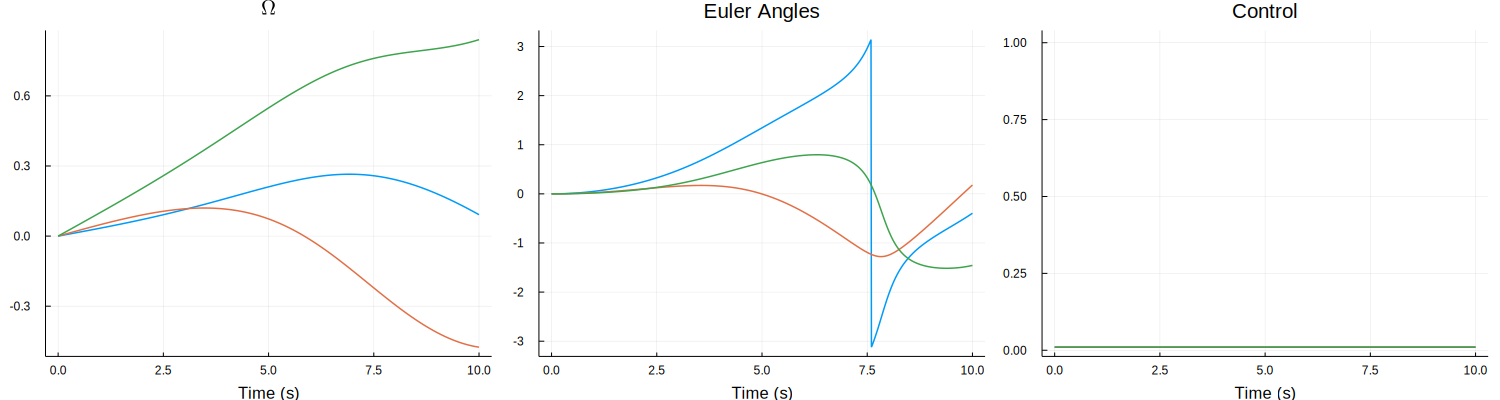

In [15]:
function propagateRK4(Omega_k, R_k, u_k; dt=0.01)
    """
    Propagate the attitude dynamics by one timestep using RK4 integration
    """
    
    Omega_F1, R_F1 = attDynamics(   Omega_k, 
                                    R_k, 
                                    u_k)
    Omega_F2, R_F2 = attDynamics(   Omega_k + Omega_F1*dt/2, 
                                    R_k*expSO3(R_F1*dt/2),
                                    u_k)
    Omega_F3, R_F3 = attDynamics(   Omega_k + Omega_F2*dt/2, 
                                    R_k*expSO3(R_F2*dt/2),
                                    u_k) 
    Omega_F4, R_F4 = attDynamics(   Omega_k + Omega_F3*dt, 
                                    R_k*expSO3(R_F3*dt),
                                    u_k) 
    
    Omega_kp1 = Omega_k + (dt/6)*(Omega_F1 + 2*Omega_F2 + 2*Omega_F3 + Omega_F4)
    R_kp1     = R_k     + (dt/6)*(R_F1     + 2*R_F2     + 2*R_F3     + R_F4)
    
    return (Omega_kp1, R_kp1)
end

function runDynamics(Omega0, R0, controller; dt=0.01, tf=10)
    """
    Run the dynamics and save R, Omega, and u
    """
    
    N = Int(tf/dt)
    
    Omega_vec = zeros(3,1,N+1)
    R_vec = zeros(3,3,N+1)
    R_no_ortho = zeros(3,3,N+1)
    u_vec = zeros(3,1,N)
    
    Omega_vec[:,:,1] = Omega0
    R_vec[:,:,1] = R0
    
    Omega_k = Omega0
    R_k = R0
       
    for k in range(1, length=N)
        t = dt*(k-1)
        u_k = controller(t, Omega_k, R_k)
        Omega_kp1, R_kp1 = propagateRK4(Omega_k, R_k, u_k, dt=dt)
        
        # orthogonalize R        
        R_kp1 = gramSchmidt(R_kp1)
                
        Omega_vec[:,:,k+1] = Omega_kp1
        R_vec[:,:,k+1] = R_kp1
        u_vec[:,:,k] = u_k
        
        Omega_k = Omega_kp1
        R_k = R_kp1
    end
    
    return Omega_vec, R_vec, u_vec
end

function testDynamics()
    
    function dumbControl(t, Omega, R)
        u = 0.01*ones(3)
        return u
    end
    
    R0 = Matrix{Float32}(LA.I, 3, 3)
    Omega0 = zeros(3)
    
    Omega_vec, R_vec, u_vec = runDynamics(Omega0, R0, dumbControl)
    
    return Omega_vec, R_vec, u_vec
end

Omega_vec, R_vec, u_vec = testDynamics()
plotDynamics(Omega_vec, R_vec, u_vec, 10)
identity(nothing)

## Control
The first controller developed by Lee is shown to be almost globally asymptotically stable and almost semi-globally exponentially stable.
* Almost globally asymptotically stable means an equilibrium point is asymptotically stable and almost all trajectories converge to it, i.e., the set of the initial states that do not asymptotically converge to the origin has zero Lebesgue measure.
* Almost semi-globally exponentially stable means an equilibrium point is asymptotically stable, and fom=r almost all initial states, there exist finite controller rparameters such that the corresponding trajectory exponentially converges to the origin.

### Simulation parameters
The following values must be defined in order to specify the controller
* $J$ - The inertia matrix of the body of interest
* $b_1$ and $b_2$ - The reference vectors defined in the body frame
* $k_1$, $k_2$, and $k_\Omega$ - The controller gains

In [13]:
J = .1*LA.Diagonal([3.0, 2.0, 1.0]) # kgm^2
b1 = [1.0, 0.0, 0.0]
b2 = [0.0, 1.0, 0.0]
k1 = 4
k2 = 4.1
kOmega = 2.8 

Delta = zeros(3) # no disturbance

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

Additionally, the desired orientation and angular velocity trajectories must be specified. These must satisfy the dynamics
$$
\dot{R}_d = \omega_d^\wedge R_d
$$
To accomplish this, we let
$$
R_d = \mathrm{exp}(\psi(t)e_3^\wedge)\mathrm{exp}(\theta(t)e_2^\wedge)\mathrm{exp}(\phi(t)e_1^\wedge)
$$
then $\omega_d$ satisfying the dynamics can be found by differenting $R_d$ and solving for $\omega_d$.

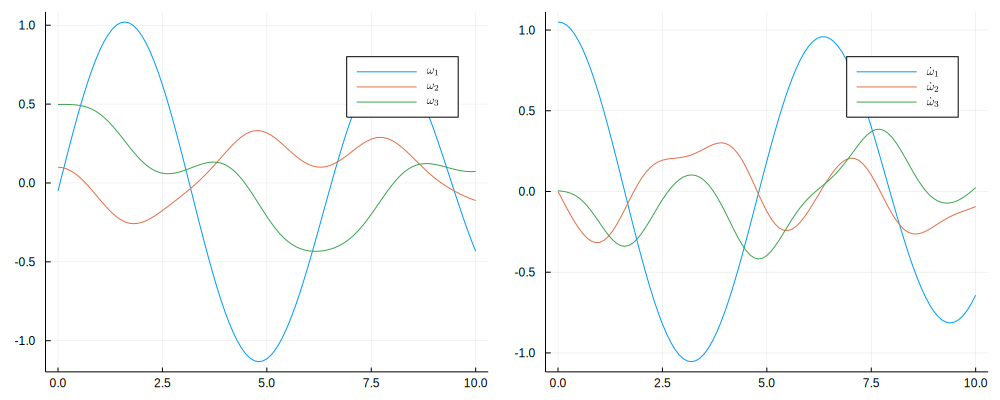

desiredVectors (generic function with 1 method)

In [17]:
expSO3dot(th, ssm) = cos(th)*ssm + sin(th)*ssm*ssm

psi(t) = 1 - cos(t)
psidot(t) = sin(t)
e1 = [1.0, 0.0, 0.0]
R_psi(t) = expSO3(psi(t)*hat(e1))
R_psidot(t) = expSO3dot(psi(t), hat(e1))*psidot(t)

theta(t) = 0.1*(-1+t)
thetadot(t) = 0.1
e2 = [0.0, 1.0, 0.0]
R_theta(t) = expSO3(theta(t)*hat(e2))
R_thetadot(t) = expSO3dot(theta(t), hat(e2))*thetadot(t)

phi(t) = sin(.5*t)
phidot(t) = .5*cos(.5*t)
e3 = [0.0, 0.0, 1.0]
R_phi(t) = expSO3(phi(t)*hat(e3))
R_phidot(t) = expSO3dot(phi(t), hat(e3))*phidot(t)

Rd(t) = R_psi(t) * R_theta(t) * R_phi(t)
Rd_dot(t) = (R_psidot(t) * R_theta(t) * R_phi(t)) + (R_psi(t) * R_thetadot(t) * R_phi(t)) + (R_psi(t) * R_theta(t) * R_phidot(t))

omegad(t) = vee(Rd_dot(t) * transpose(Rd(t)))
omegad_dot(t) = ForwardDiff.derivative(omegad, t)

tvec = 0:.1:10

omegad_vec = omegad.(tvec)
omegad_plot = plot(tvec, hcat(omegad_vec...)[1,:], label=L"\omega_1")
plot!(tvec, hcat(omegad_vec...)[2,:], label=L"\omega_2")
plot!(tvec, hcat(omegad_vec...)[3,:], label=L"\omega_3")

omegad_dot_vec = ForwardDiff.derivative.(omegad, tvec)
omegad_dot_plot = plot(tvec, hcat(omegad_dot_vec...)[1,:], label=L"\dot{\omega}_1")
plot!(tvec, hcat(omegad_dot_vec...)[2,:], label=L"\dot{\omega}_2")
plot!(tvec, hcat(omegad_dot_vec...)[3,:], label=L"\dot{\omega}_3")
display(plot(omegad_plot, omegad_dot_plot, layout=(1,2), size=(2*500, 400)))

Rd_vec = Rd.(tvec)

Rd_dot_vec = Rd_dot.(tvec)
Rd_dot_vec_ad = ForwardDiff.derivative.(Rd, tvec)

isapprox(Rd_dot_vec, Rd_dot_vec_ad)

function desiredVectors(dt, tf)
    N = Int(tf/dt)
    
    Omegad_vec = zeros(3,1,N+1)
    Rd_vec = zeros(3,3,N+1)
    for k = 1:N+1
        t = dt*(k-1)
        Rd_vec[:,:,k] = Rd(t)
        Omegad_vec[:,:,k] = Rd_vec[:,:,k]' * omegad(t) # rotate inertial omega to body frame
    end
    
    return Omegad_vec, Rd_vec
end

### The actual controller
The attitude tracking controller assuming no disturbance is
$$
u = -e_r - k_\Omega e_\Omega + (R^T \omega_d)^\wedge J R^T \omega_d + J R^T \dot{\omega}_d
$$
where 
$$
e_r = k_1 e_{r_1} + k_2 e_{r_2} = k_1(R^T r_{1_d} \times b_1) + k_2(R^T r_{2_d} \times b_2) 
$$
and
$$
e_\Omega = \Omega - R^T \omega_d
$$
with
$$
r_{i_d} = R_d b_i
$$

In [11]:
function controller1(t, Omega_k, R_k)
    """
    The Attitude Tracking with No Disturbance contoller
    """
    Rd_k = Rd(t)
    omegad_k = omegad(t)
    omegad_dot_k = omegad_dot(t)
    
    r1d = Rd_k*b1
    r2d = Rd_k*b2
    
    e_r1 = crossMat(R_k'*r1d)*b1
    e_r2 = crossMat(R_k'*r2d)*b2
    
    e_r = k1*e_r1 + k2*e_r2
    
    e_Omega = Omega_k - R_k'*omegad_k
    
    u = -e_r - kOmega*e_Omega + hat(R_k'*omegad_k)*J*R_k'*omegad_k + J*R_k'*omegad_dot_k
    
    return u
end

controller1 (generic function with 1 method)

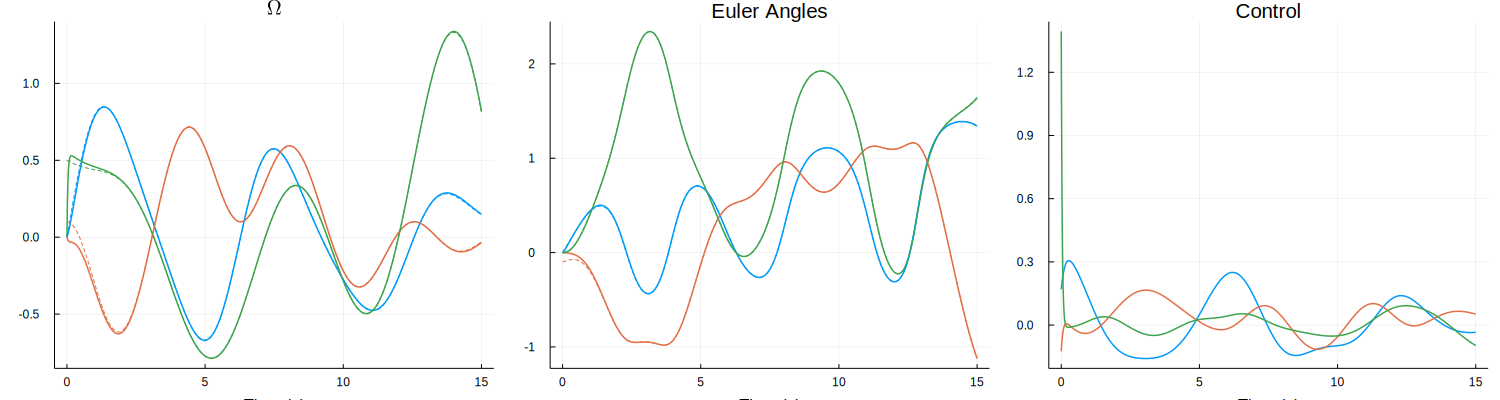

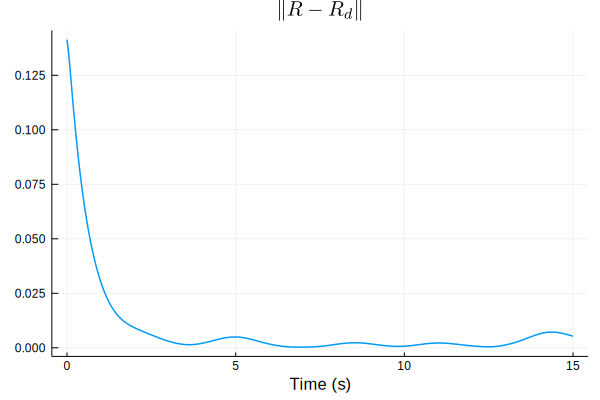

In [16]:
function runCase1()
    dt = .01
    tf = 15
    R0 = Matrix{Float32}(LA.I, 3, 3)
    Omega0 = zeros(3)
    
    Omega_vec, R_vec, u_vec = runDynamics(Omega0, R0, controller1, dt=dt, tf=tf)
    
    Omegad_vec, Rd_vec = desiredVectors(dt, tf)
    p_omega, p_R, p_u = plotDynamics(Omega_vec, R_vec, u_vec, tf, Omegad_vec=Omegad_vec, Rd_vec=Rd_vec)
    savefig(p_omega, "case1_Omega.png")
    savefig(p_R, "case1_euler.png")
    savefig(p_u, "case1_control.png")
    
    Rerr = LA.norm(R_vec .- Rd_vec)
    p_Rerr = plotRerr(R_vec, Rd_vec, tf)
    display(p_Rerr)
    savefig(p_Rerr, "case1_Rerr.png")
    return Omega_vec, R_vec, u_vec
end

runCase1()

identity(nothing)

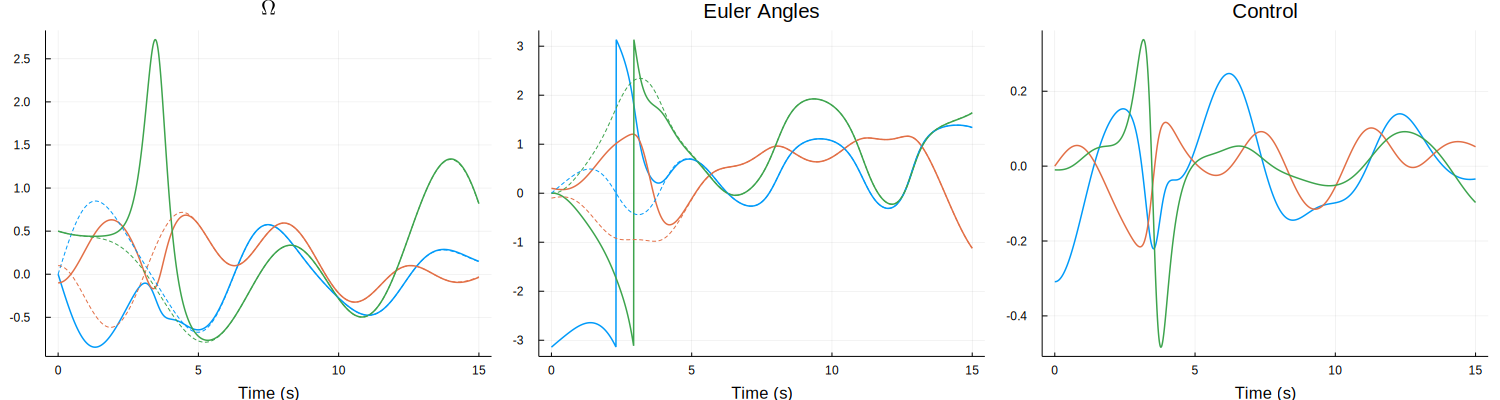

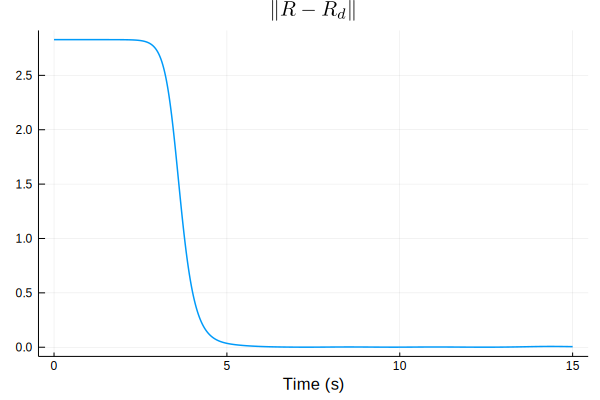

In [13]:
function runCase2()
    dt = .01
    tf = 15
    
    # start far from the desired state
    Rd0 = Rd(0.0)
    r1d0 = Rd0*b1
    r2d0 = Rd0*b2
    R0 = expSO3(1*pi*hat(crossMat(r1d0)*r2d0))*Rd0
    Omega0 = R0' * omegad(0.0)
    
    Omega_vec, R_vec, u_vec = runDynamics(Omega0, R0, controller1, dt=dt, tf=tf)
    
    Omegad_vec, Rd_vec = desiredVectors(dt, tf)
    p_omega, p_R, p_u = plotDynamics(Omega_vec, R_vec, u_vec, tf, Omegad_vec=Omegad_vec, Rd_vec=Rd_vec)
    savefig(p_omega, "case2_Omega.png")
    savefig(p_R, "case2_euler.png")
    savefig(p_u, "case2_control.png")
    
    Rerr = LA.norm(R_vec .- Rd_vec)
    p_Rerr = plotRerr(R_vec, Rd_vec, tf)
    display(p_Rerr)
    savefig(p_Rerr, "case2_Rerr.png")
    return Omega_vec, R_vec, u_vec
end

runCase2()

identity(nothing)